In [1]:
import os 
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter, FuncFormatter

pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 50)
pd.options.display.float_format = '{:,.4f}'.format

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

# Makes graphs crisp. Only use if you don't have a lot of points/lines on your graph.
%config InlineBackend.figure_formats = ['svg', 'retina'] # use svg, then retina if svg is not supported

np.random.seed(42)

In [2]:
# set paths and create dirs 
base_dir = '../..'
data_dir = os.path.join(base_dir, 'data')
helper_dir = os.path.join(base_dir, 'helper')
output_dir = os.path.join(base_dir, 'output')
png_dir = os.path.join(output_dir, 'png')
csv_dir = os.path.join(output_dir, 'csv')
os.makedirs(png_dir, exist_ok=True)
os.makedirs(csv_dir, exist_ok=True)

In [3]:
# load helper functions
%run {helper_dir}/plot.py
%run {helper_dir}/mc_frequentist.py

## Input

In [4]:
chain = 'Avalanche'

In [5]:
if chain == 'Arbitrum':
    text_lab1_y1pos = 0.9e-5
    text_lab1_y2pos = 0.8e-5
    text_lab2_y1pos = .8e-5
    text_lab2_y2pos = 0.7e-5
else:
    text_lab1_y1pos = 1.5e-5
    text_lab1_y2pos = 1.25e-5
    text_lab2_y1pos = .8e-5
    text_lab2_y2pos = 0.7e-5

In [6]:
data_fnames = os.listdir(os.path.join(data_dir, chain)) # names of all data files

# collect the names of the files for this analysis
fnames = dict()
for fname in data_fnames:
    if fname.startswith('Fees'):
        fnames['Fees'] = fname
    if fname.startswith('Traders Net PnL'):
        fnames['Traders Net PnL'] = fname
fnames

{'Traders Net PnL': 'Traders Net PnL_2021-12-22_2022-10-29.csv',
 'Fees': 'Fees_2021-12-22_2022-10-29.csv'}

## Prep Data

### Fees Paid by Traders

In [7]:
# only read the first 7 cols since the last col "Cumulative" is NOT the daily total, but cumulative daily total, 
# which we don't want.
df_fees = pd.read_csv(os.path.join(data_dir, chain, fnames['Fees']), 
                      parse_dates=['Date'], index_col='Date', usecols=range(6))
df_fees.columns = df_fees.columns.str.lower().str.replace(' ', '_') + '_fees'

# only margin trading and liquidation fees are paid by traders
df_trader_fees = df_fees.loc[:, ['margin_trading_fees', 'liquidation_fees']]

# calc daily total 
df_trader_fees['trader_fees'] = df_trader_fees.sum(axis=1)

df_trader_fees.head()

,margin_trading_fees,liquidation_fees,trader_fees
Date,,,
2021-12-22,0.0241,0.0000,0.0241
2021-12-27,0.2072,0.0000,0.2072
2021-12-30,1.1119,0.0000,1.1119
2021-12-31,0.6245,0.0000,0.6245
2022-01-02,0.9837,0.0000,0.9837


### Traders' PnL

In [8]:
df_trader_pnl = (pd.read_csv(os.path.join(data_dir, chain, fnames['Traders Net PnL']), 
                             parse_dates=['Date'], index_col='Date', usecols=range(2))
                   .rename(columns = {'Net PnL': 'trader_pnl_before_fees'})
                )
df_trader_pnl.head()

,trader_pnl_before_fees
Date,
2021-12-22,0.0000
2021-12-27,0.0000
2021-12-30,-4.5341
2021-12-31,-4.3827
2022-01-02,-6.4172


### Join and Clean up

In [9]:
df = df_trader_pnl.join(df_trader_fees[['trader_fees']])
df['trader_pnl_after_fees'] = df.trader_pnl_before_fees - df.trader_fees 

# drop the last row because the most recent date may not be a full day
# drop the first row because it's the first day and public hasn't started using the platform yet
df = df.iloc[1:-1, :]

if chain == 'Avalanche':
    df = df.loc['2022-01-07':, :] # all days before have tiny numbers, probably before official launch or people don't know
df

,trader_pnl_before_fees,trader_fees,trader_pnl_after_fees
Date,,,
2022-01-07,"-80,919.1562","10,137.6332","-91,056.7894"
2022-01-08,"-69,470.7784","12,496.2306","-81,967.0090"
2022-01-09,"8,843.4742","79,978.7676","-71,135.2934"
2022-01-10,"568,019.4090","128,827.8689","439,191.5401"
2022-01-11,"-56,453.4100","111,593.3481","-168,046.7582"
...,...,...,...
2022-10-24,"11,828.9531","23,711.4500","-11,882.4969"
2022-10-25,"242,585.7985","59,617.8042","182,967.9943"
2022-10-26,"45,358.6416","75,560.0460","-30,201.4044"


## Sampling Distribution of Traders' (sample) Mean PnL 

In [10]:
def run_sampling_dist_traders_pnl(yvar, xlim_lwr=None, xlim_upr=None):
    sample_profile = dict(size = len(df), start_dt = df.index.min().date(), end_dt = df.index.max().date())
    
    # calc sample avg and standard error
    avg_n_se = df[yvar].agg([np.mean, lambda x: np.std(x, ddof=1)/np.sqrt(len(x))])
    avg_n_se.index = ['avg', 'se']
    
    # generate the sampling distribution of the sample mean
    avg_pnls = np.random.normal(avg_n_se['avg'], avg_n_se['se'], size=50000000)

    # calculate prob(mean > 0), prob(mean > 50k) 
    prob_avg_pnl_gt0 = np.sum(avg_pnls > 0) / len(avg_pnls)
    prob_avg_pnl_gt50k = np.sum(avg_pnls > 50_000) / len(avg_pnls)

    # plot
    subfnm = yvar.replace('trader_pnl', '')
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.hist(avg_pnls, 100, density=True, facecolor='g', alpha=0.75)[0]
    ax.text(xlim_lwr+50_000, text_lab1_y1pos,
            r'$\mu={:,.0f},\ \sigma={:,.0f}$'.format(avg_n_se.loc['avg'], avg_n_se.loc['se']))
    ax.text(xlim_lwr+50_000, text_lab1_y2pos,
            '$\mu, \sigma$ were calculated using {} days of\ndata from {} to {}.'\
         .format(sample_profile['size'], sample_profile['start_dt'], sample_profile['end_dt']))
    ax.text(10_000, text_lab2_y1pos,
            "P(mean daily PnL > 0)={:.3%}".format(prob_avg_pnl_gt0))
    ax.text(10_000, text_lab2_y2pos, 
            "P(mean daily PnL > $50k)={:.3%}".format(prob_avg_pnl_gt50k))    
    ax.axvline(x=0)
    if xlim_lwr and xlim_upr:
        ax.set_xlim([xlim_lwr, xlim_upr])
    ax.set_title("Sampling Distribution of {} Traders' Mean Daily PnL {}".format(chain, subfnm.replace('_', ' ').title()))    
    ax.set_xlabel("Traders' Mean Daily PnL {}".format(subfnm.replace('_', ' ').title()))
    ax.set_ylabel('Density')
    formatter = FuncFormatter(human_format_dollar_or_num(dollar=True, decimals=0))
    ax.xaxis.set_major_formatter(formatter)

    fig.tight_layout()
    fnm = "traders_mean_daily_pnl" + subfnm + ".png"
    fig.savefig(os.path.join(png_dir, chain, fnm), dpi=300);    

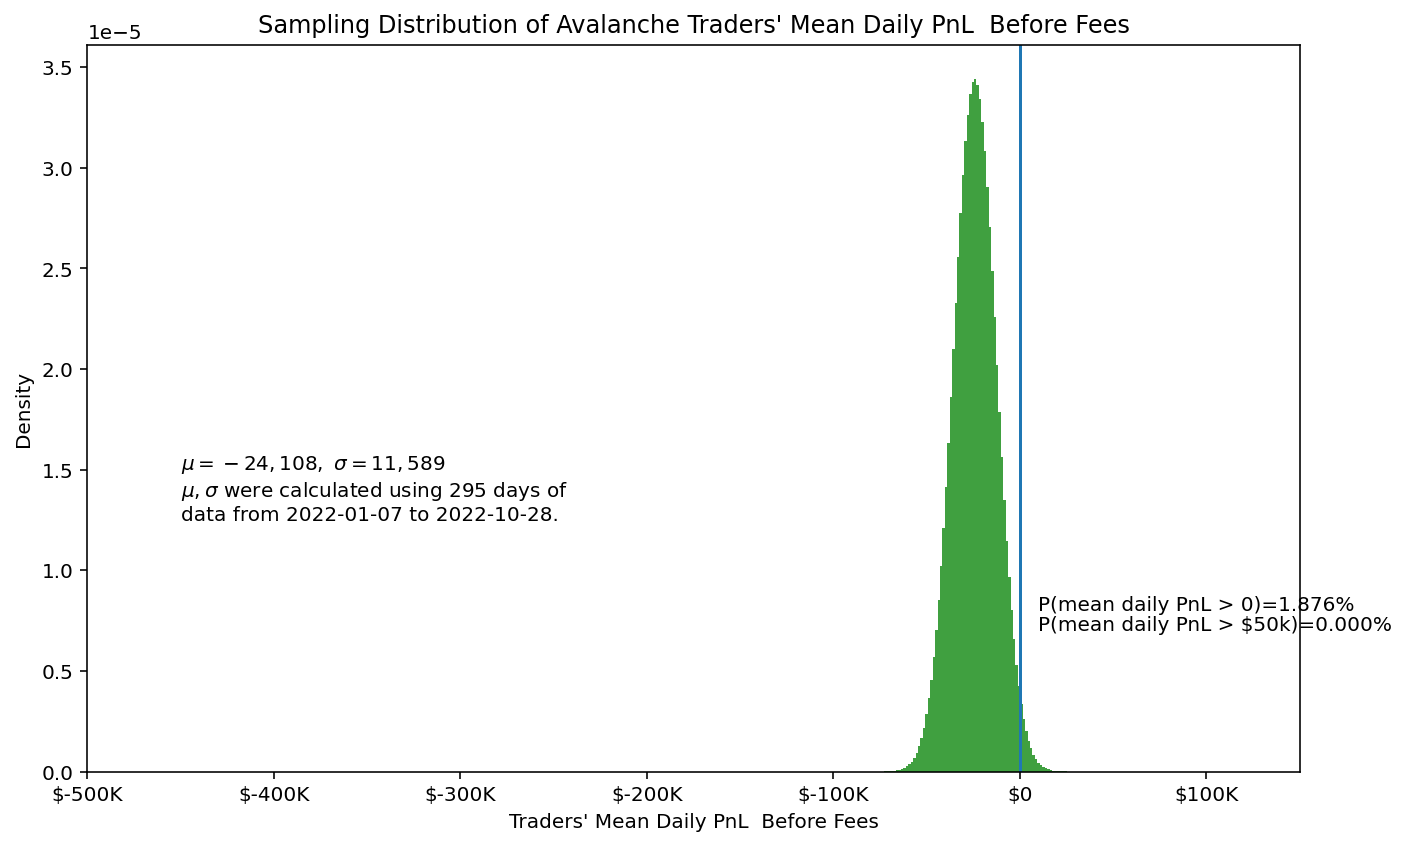

In [11]:
run_sampling_dist_traders_pnl('trader_pnl_before_fees', xlim_lwr = -500_000, xlim_upr = 150_000)

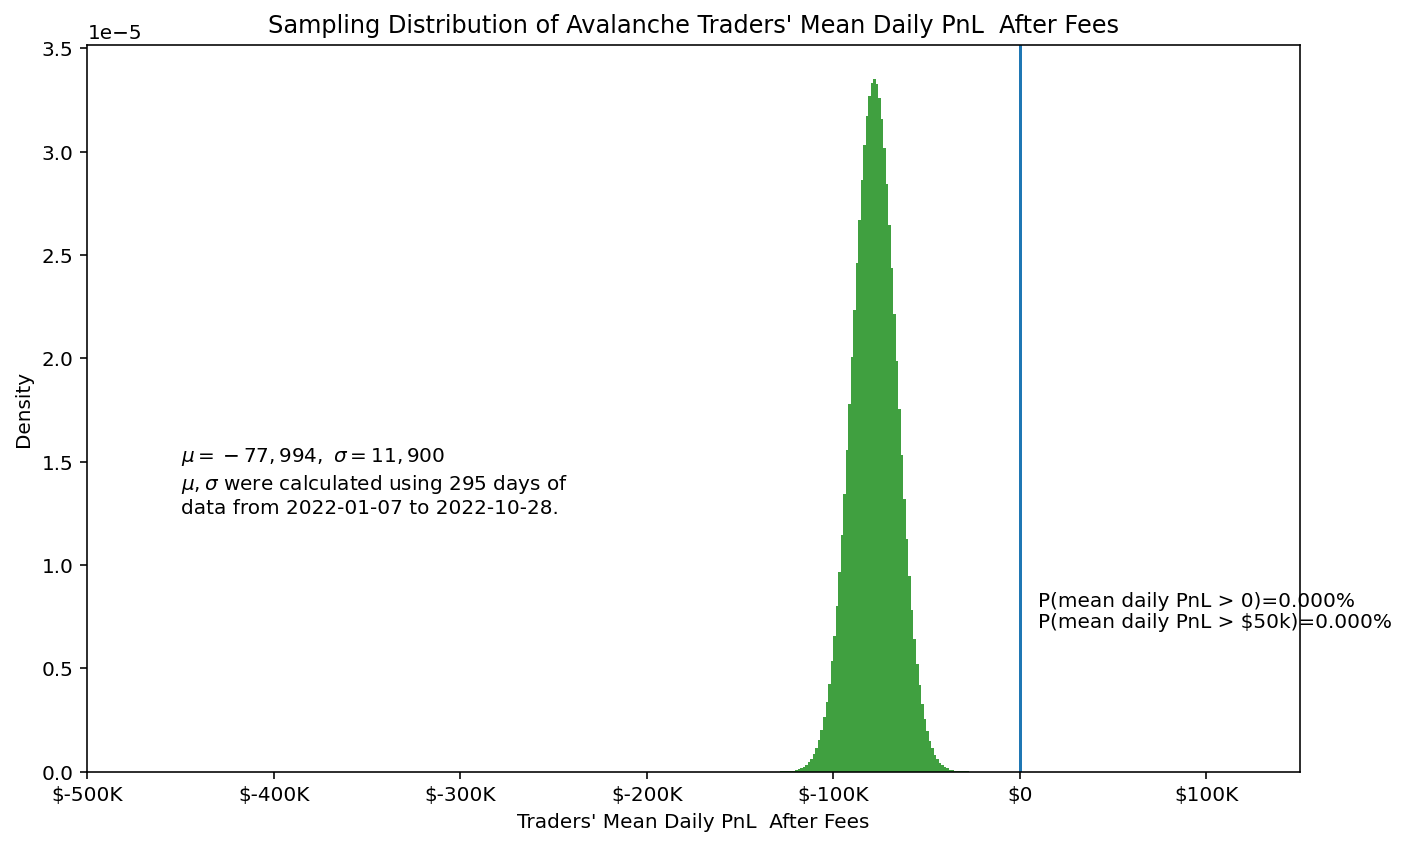

In [12]:
run_sampling_dist_traders_pnl('trader_pnl_after_fees', xlim_lwr = -500_000, xlim_upr = 150_000)